# Exercise - Multivariate Linear Regression with PyTorch

## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements) 
  * [Knowledge](#Knowledge) 
  * [Modules](#Python-Modules)
* [Training Data](#Training-Data)  
* [Exercises - Multivariate Linear Regression](#Exercises---Multivariate-Linear-Regression)
  * [Model](#Model)
  * [Training and Evaluation](#Training-and-Evaluation)
* [Summary and Outlook](#Summary-and-Outlook)
* [Literature](#Literature) 
* [Licenses](#Licenses)

## Introduction

In this exercise you will implement the _multivariate linear regression_, a model with two or more predictors and one response variable (opposed to one predictor using univariate linear regression). The whole exercise consists of the following steps:

1. Implement a linear function as hypothesis (model) 
2. Plot the $((x_1, x_2), y)$ values in a 3D plot.
3. Write a function to quantify your model (cost function)
4. Implement the gradient descent algorithm to train your model (optimizer) 
5. Visualize your training process and results

## Requirements
### Knowledge
You should have a basic knowledge of Machine Learning models, cost functions, optimization algorithms and also numpy and matplotlib. We will only recap these concepts for a better understanding and do not explain them in great detail. Suitable sources for acquiring this knowledge are:
- [Simple Linear Regression Notebook](http://christianherta.de/lehre/dataScience/machineLearning/basics/univariate-linear-regression.php) by Christian Herta and his [lecture slides](http://christianherta.de/lehre/dataScience/machineLearning/linearRegression.pdf) (German)
- [Multivariate Linear Regression Notebook](http://christianherta.de/lehre/dataScience/machineLearning/basics/multivariate_linear_regression.php) by Christian Herta and his [lecture slides](http://christianherta.de/lehre/dataScience/machineLearning/multivariateLinearRegression.pdf) (German)
- Chapter 5.1 of [Deep Learning](http://www.deeplearningbook.org/contents/ml.html) by Ian Goodfellow 
- Some parts of chapter 1 and 3 of [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book) by Christopher M. Bishop
- [numpy quickstart](https://docs.scipy.org/doc/numpy-1.15.1/user/quickstart.html)
- [Matplotlib tutorials](https://matplotlib.org/tutorials/index.html)
- [PyTorch quickstart tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)

### Python Modules

By [deep.TEACHING](https://www.deep-teaching.org/) convention, all python modules needed to run the notebook are loaded centrally at the beginning. 


In [ ]:
# Import Numpy & PyTorch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from mpl_toolkits.mplot3d.axes3d import Axes3D

## Trianing Data

First, let us generate some training data:

- $m$-Training data $\mathcal D = \{(\vec x^{(1)}, y^{(1)}),(\vec x^{(2)},y^{(2)}), \dots (\vec x^{(m)},y^{(m)})\}$

here with
 - $m=100$ training data
 - two features $x_1, x_2 \in [0, 10]$
 - one target value (float): $y = 1 + 2 \cdot x_1 + 3 \cdot x_2 + \eta$
 - gaussian noise $\eta$
 
Note that in reality, we do not know the true target function. If we did, we already knew the perfect model and  did not have to find one.

In [ ]:
### seed for reproducability
np.random.seed(42)

m = 100
n = 2

X = np.random.uniform(low=0, high=10, size=(m,n))

### convert from float64 to float32 for various reasons:
### speedup, less memory usage, precision is enough.
### when using GPU, fp16, fp32 or fp64 depends on
### type of GPU (consumer/workstation/server).
X = np.array(X, dtype=np.float32) 

print(X.shape)
print(X.dtype)

In [ ]:
def true_target_function(x):
    t0 = 1
    t1 = 2
    t2 = 3
    noise = np.random.randn(len(x)) *5
    return t0 + t1 * x[:,0] + t2 * x[:,1] + noise

In [ ]:
y = true_target_function(X)
y = np.array(y, dtype=np.float32)

print(y.shape)
print(y.dtype)

### Plot The Data

Let us plot the data $D = \{(x^{(1)}_1,x^{(1)}_2,y^{(1)}), \ldots, (x^{(n)}_1,x^{(n)}_2,y^{(n)})\}$ in a 3D scatter plot.

**Sidenote:**

The command `%matplotlib notebook` (instead of `%matplotlib inline`) creates an interactive (e.g. rotatable) plot.

In [ ]:
%matplotlib notebook

def plot_data_scatter(features, targets):
    """ Plots the features and the targets in a 3D scatter plot
    
    Args:
        features: 2D numpy-array features
        targets: ltargets
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(features[:,0], features[:,1], targets, c='r')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$y$')
    return ax

In [ ]:
plot_data_scatter(X, y)

## Exercise - Multivariate Linear Regression

We will only use two features in this notebook, so we are still able to plot them together with the target in a 3D plot. But your implementation should also be capable of handling more (except the plots). 

A short recap, a hypothesis $h_\theta(x)$ is a certain function that we believe is similar to a target function that we like to model.

## Model

Here we have $n$ features $x = [x_1, \ldots, x_n ]$ and $n+1$ $\theta$s:

$$
h_\theta(x) = \theta_{0} + \theta_{1} x_1 + \ldots \theta_n x_n 
$$




### Converting Data to Tensors

For PyTorch to be able to work with the data, we need to convert the numpy arrays.

In [ ]:
### for pytorch, shape (m,1), 100x1 matrix, is crucial.
### shape (100), just a vector, can mess up calculations.
X_tensor = torch.from_numpy(X.reshape(m,n))
y_tensor = torch.from_numpy(y.reshape(m,1))

print(X.shape)
print(y.shape)
print(X_tensor.shape)
print(y_tensor.shape)

### Define the Model

**Task:**
    
Implement the class `LinearRegression`, which uses `torch.nn.Linear` for our hypothesis.

$$
h_\theta(x) = \theta_{0} + \theta_{1} x_1 + \ldots \theta_n x_n 
$$

In [ ]:
#######################################
### Using built-in linear function ####
#######################################

class LinearRegression(nn.Module):  # inheriting from nn.Module!

    def __init__(self, n_features):
        super(LinearRegression, self).__init__()
        
        ###############################
        ##### YOUR SOLUTION START #####
        ###############################
        ##
        ## Task (1): add torch.nn.Linear as a class-member
        ##

        raise NotImplementedError()

        ###############################
        ##### YOUR SOLUTION End   #####
        ############################### 
        
    def forward(self, x):
        ###############################
        ##### YOUR SOLUTION START #####
        ###############################
        ##
        ## Task (2): call the member function on x and return the result
        ##

        raise NotImplementedError()

        ###############################
        ##### YOUR SOLUTION End   #####
        ############################### 

In [ ]:
#######################################
### Using built-in linear function ####
#######################################

class LinearRegression(nn.Module):  ### inheriting from nn.Module!

    def __init__(self, n_features):
        super(LinearRegression, self).__init__()
        
        ###############################
        ##### YOUR SOLUTION START #####
        ###############################
        ##
        ## Task (1): add torch.nn.Linear as a class-member
        ##

        self.linear = nn.Linear(in_features=n_features, out_features=1)

        ###############################
        ##### YOUR SOLUTION End   #####
        ############################### 
        
    def forward(self, x):
        ###############################
        ##### YOUR SOLUTION START #####
        ###############################
        ##
        ## Task (2): call the member function on x and return the result
        ##

        return self.linear(x)

        ###############################
        ##### YOUR SOLUTION End   #####
        ############################### 

Now we can already make some predictions with our model.

In [ ]:
### define model, generate predictions
NUM_FEATURES = n
model = LinearRegression(n_features=NUM_FEATURES)
y_predicted = model(X_tensor)

### output should look like:
### torch.Size([100, 1])
print(y_predicted.shape)

### Training and Evaluation

**Task:**

Write the code to train your model:

* Create a new model object before the training.


* Scale your features before the training so they are in the range of $-1$ to $+1$: 
    * $X_{scaled} = \frac{X - \mu}{std(X)}$
    * IMPORTANT: Calculate the mean $\mu$ and the standard deviation $std$ for each feature individually
    
    
* Use the built-in for the Mean-Squared-Error loss `torch.nn.MSELoss()`:
  * create an object once before the training, e.g. `criterion = torch.nn.MSELoss()`
  * calling it will give you a tensor, e.g. `loss = criterion(y_tensor, predictions)`
  * you an call `backward()` on that tensor too
  
  
* Also use a built-in optimizer, e.g. `torch.optim.Adam`:
  * create an object once before the training providing your `model.parameters()` and a learning rate as argument
  * use its functions `step()` and `zero_grad()` to update the parameters, resp. to reset the gradient
  
  
* Keep track of the costs in each epoch to plot them afterwards

In [ ]:
### If we do not call figure() here, plot would go
### into the scatter plot some cells above 
### (reason [%matplotlib notebook] magic command)
plt.figure()

### Hyperparameters
learning_rate = 1
epochs = 1000
costs = []
mean = []
std = []



###############################
##### YOUR SOLUTION START #####
###############################
##
## Task (0): Scale your features
##
## Task (1): Iteratively train your model using the classes and functions mentioned
##
## Task (2): Plot the history of the costs afterwards
##

###############################
##### YOUR SOLUTION End   #####
###############################  

### Plot the decision boundary

Finally let us plot the decision hyperplane (just a plain plane here though) together with the data in a 3D plot.

**Task:**

Just make sure your trained model object is available in the context of the cell below and is called `model`.

The plot should look like the following:

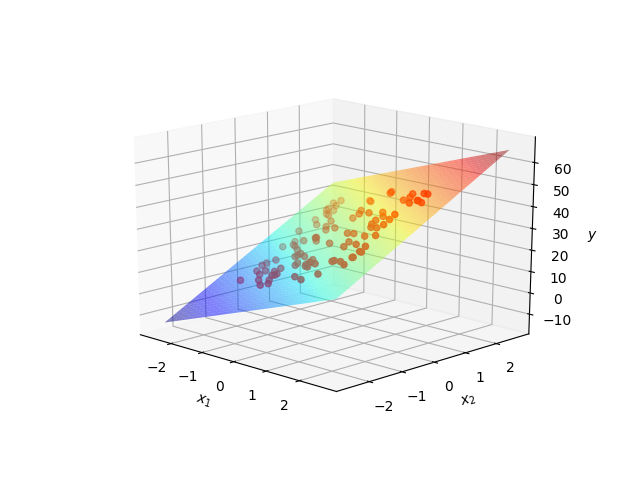

In [ ]:
def plot_decision_bounday(X, mean, std, model, ax):
    g = 100
    x_1 = np.linspace((X[:,0].min()-1), (X[:,0].max()+1), g, dtype=np.float32)
    x_2 = np.linspace((X[:,1].min()-1), (X[:,1].max()+1), g, dtype=np.float32)

    ### IMPORTANT: As we trained our model with scaled X, we need to scale new data
    ### (here the grid IS new data) also with the same mean and std we already calculated
    x_1 = (x_1 - X.mean(axis=0)[0]) / X.std(axis=0)[0]
    x_2 = (x_2 - X.mean(axis=0)[1]) / X.std(axis=0)[1]

    
    X1, X2 = np.meshgrid(x_1, x_2)
    X_mesh = np.zeros((g**2,2), dtype=np.float32)
    X_mesh[:,0] = X1.flatten()
    X_mesh[:,1] = X2.flatten()
    Y = model(torch.tensor(X_mesh)).detach().numpy()
    ax.plot_surface(X1, X2, Y.reshape((g,g)), cmap=cm.jet, antialiased=True, shade=True, alpha=0.5, linewidth=0.)
    return ax
    

    
ax = plot_data_scatter(X_tensor, y_tensor)

### Here we pass our trained model into the function
plot_decision_bounday(X, mean, std, model, ax)

## Summary and Outlook

During this exercise, the linear regression was extended to multidimensional feature space, here with two features only for visualization purpose. Though, handling even more features works exactly the same way.

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Exercise: Multivariate Linear Regression with PyTorch <br/>
by Christian Herta, Klaus Strohmenger <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018 Christian Herta, Klaus Strohmenger

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.